In [10]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyCompare
from scipy.stats import zscore
import statsmodels.stats.weightstats as tests
from scipy import stats
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
np.set_printoptions(precision=4, suppress=True)

In [11]:
df = pd.read_csv("data.csv")
type = "activity"
property = "steps"
df.tail()

,bedtimeStart,Date,bedtimeEnd,Type,Provider,sleepScore,date,lightSleepDuration,sleepLatency,sleepEfficiency,...,remSleepDuration,CreatedAt,type,totalSleepDuration,averageHR,intenseActivity,caloriesBurned,steps,moderateActivity,softActivity
388,NaN,2024-03-22,NaN,activity_Withings,Withings,NaN,2024-03-22,NaN,NaN,NaN,...,NaN,1711322253,activity,NaN,NaN,0.0,426.860,6115.0,4740.0,960.0
389,NaN,2024-03-23,NaN,activity_Withings,Withings,NaN,2024-03-23,NaN,NaN,NaN,...,NaN,1711322255,activity,NaN,NaN,0.0,25.720,687.0,60.0,1080.0
390,NaN,2024-03-24,NaN,activity_Withings,Withings,NaN,2024-03-24,NaN,NaN,NaN,...,NaN,1711416912,activity,NaN,NaN,0.0,17.330,475.0,60.0,1080.0
391,NaN,2024-03-25,NaN,activity_Withings,Withings,NaN,2024-03-25,NaN,NaN,NaN,...,NaN,1711479655,activity,NaN,NaN,0.0,809.106,9690.0,8938.0,2880.0
392,NaN,2024-03-26,NaN,activity_Withings,Withings,NaN,2024-03-26,NaN,NaN,NaN,...,NaN,1711490235,activity,NaN,NaN,0.0,262.195,5173.0,2640.0,3000.0


In [12]:
categoriesSleep = ["sleepScore", "lightSleepDuration", "sleepLatency", "sleepEfficiency", "totalSleepDuration", "averageHR" ]
categoriesActivity = ["intenseActivity",
            "caloriesBurned", "steps", "moderateActivity", "softActivity"]
df_oura = df.loc[df["Type"] == f"sleep_Oura"]
df_withings = df.loc[df["Type"] == f"sleep_Withings"]
df_oura = df_oura[df_oura["date"].isin(df_withings["date"])]
# df_oura = df_oura[df_oura[property].notna()]
df_withings = df_withings[df_withings["date"].isin(df_oura["date"])]
# df_withings = df_withings[df_withings[property].notna()]
df_oura.set_index('date', inplace=True)
df_withings.set_index('date', inplace=True)
resultSleep = df_oura[categoriesSleep].sub(df_withings[categoriesSleep])
df_oura = df.loc[df["Type"] == f"activity_Oura"]
df_withings = df.loc[df["Type"] == f"activity_Withings"]
df_oura = df_oura[df_oura["date"].isin(df_withings["date"])]
# df_oura = df_oura[df_oura[property].notna()]
df_withings = df_withings[df_withings["date"].isin(df_oura["date"])]
# df_withings = df_withings[df_withings[property].notna()]
df_oura.set_index('date', inplace=True)
df_withings.set_index('date', inplace=True)
resultActivity = df_oura[categoriesActivity].sub(df_withings[categoriesActivity])
print(len(resultSleep))
print(len(resultActivity))

59
66


sleepScore: 55
lightSleepDuration: 56
sleepLatency: 54
sleepEfficiency: 56
totalSleepDuration: 53
averageHR: 49
intenseActivity: 62
caloriesBurned: 61
steps: 60
moderateActivity: 63
softActivity: 60
0.2659507557680344


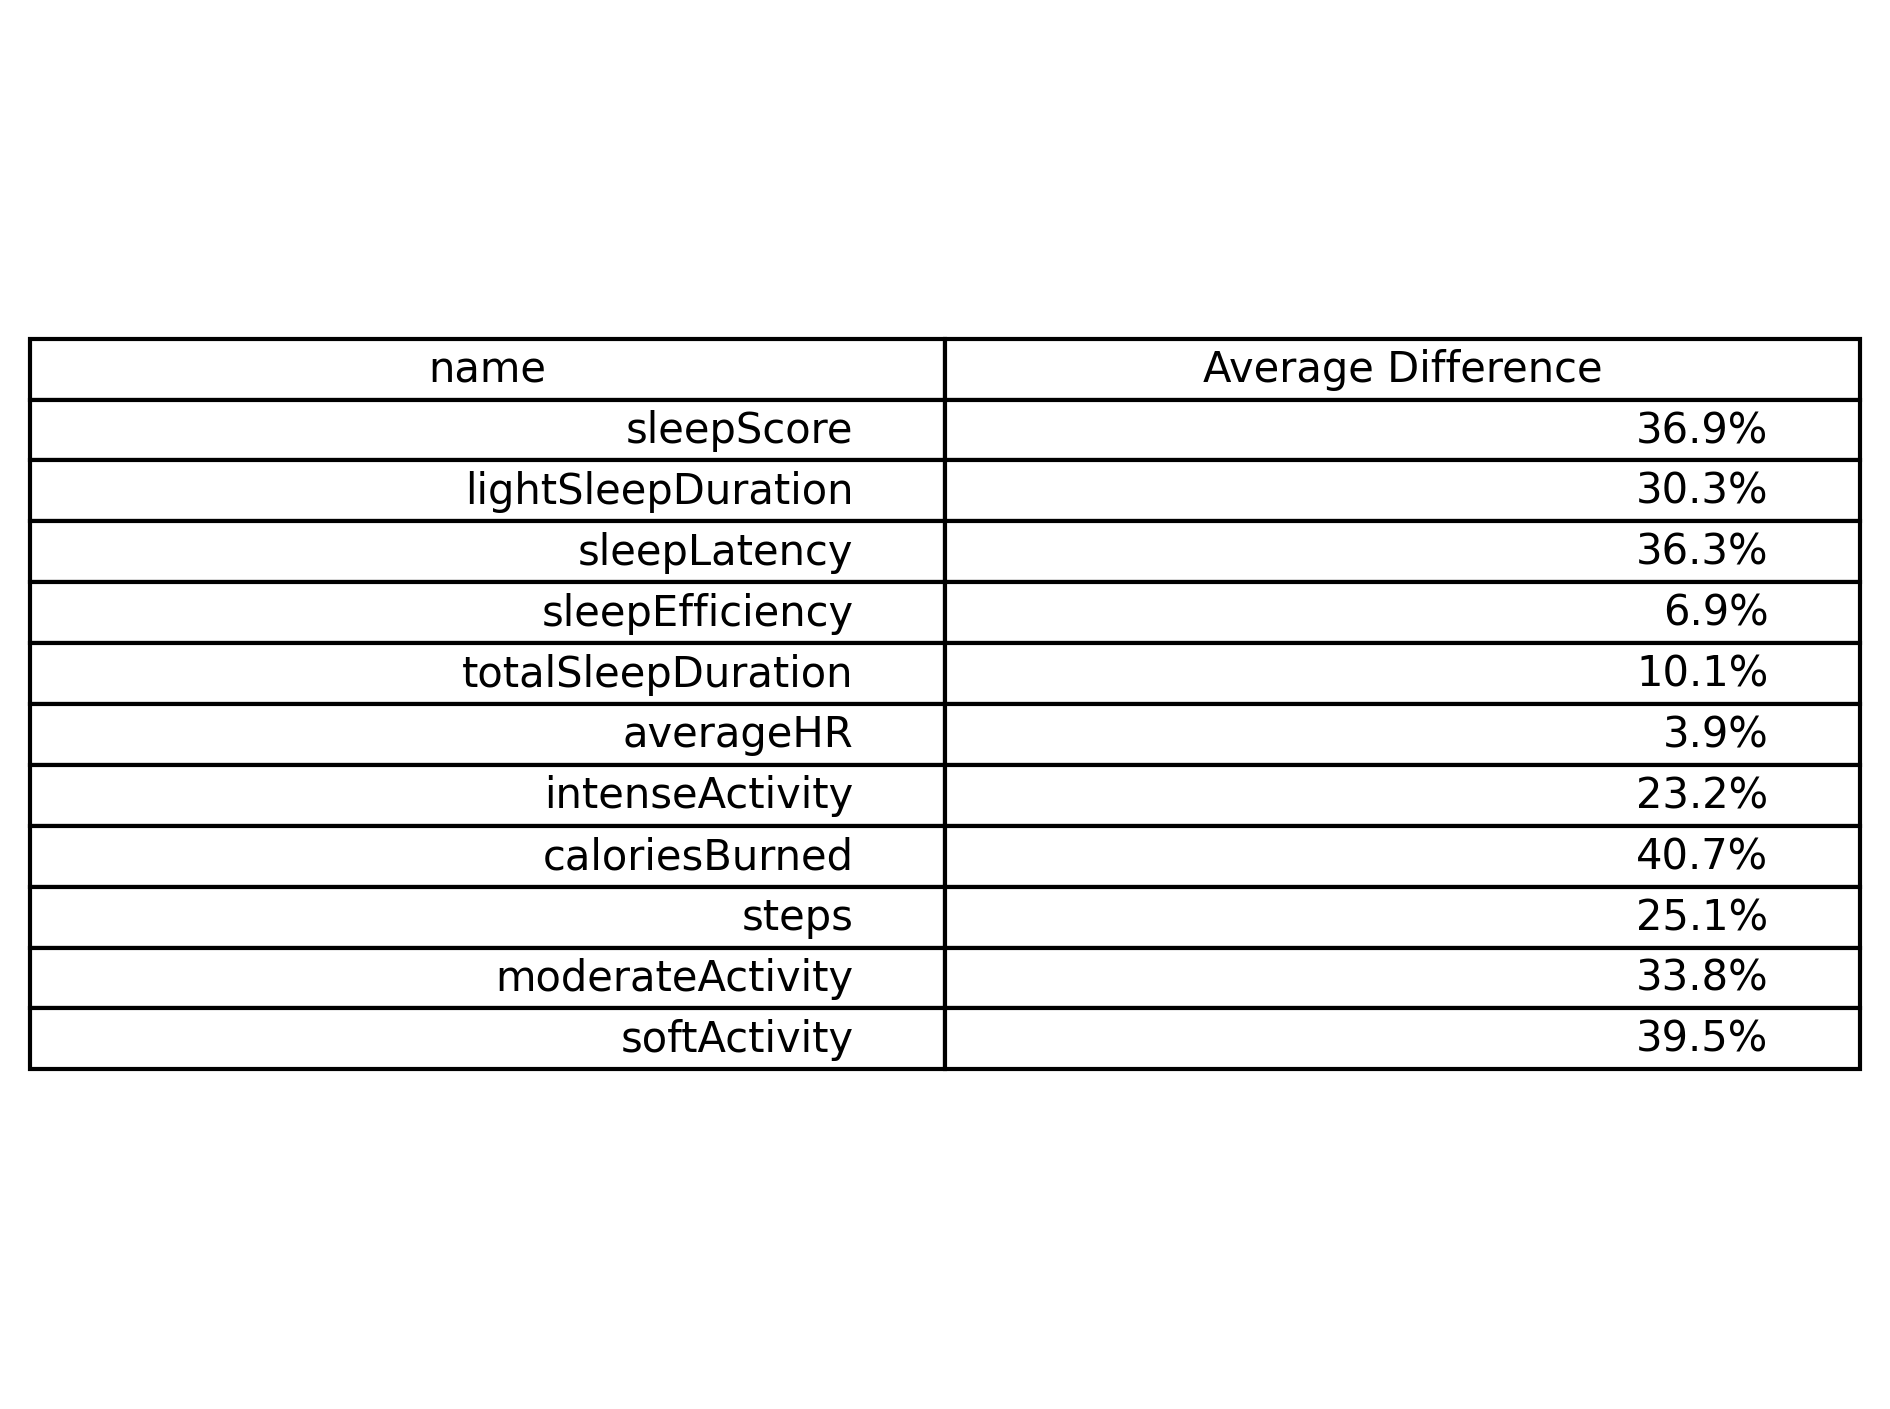

In [13]:
import math
Q = 0
N = 0
a_lst = []
b_lst = []
zscoreOutlier = 2
table_df = []
for p in categoriesSleep:
    lst = []
    df_oura = df.loc[df["Type"] == f"sleep_Oura"]
    df_withings = df.loc[df["Type"] == f"sleep_Withings"]
    df_oura = df_oura[df_oura["date"].isin(df_withings["date"])]
    df_withings = df_withings[df_withings["date"].isin(df_oura["date"])]
    df_oura.reset_index(inplace=True)
    df_withings.reset_index(inplace=True)
    zscores = zscore(resultSleep[p]).values

    for i, row in df_oura.iterrows():
        a = max(row[p], 0.00001)
        b = df_withings.loc[df_withings["date"] == row["date"]]
        b = max(0.00001, b.iloc[0][p])
        if  math.isnan(a) or math.isnan(b):
            continue
        temp = zscores[i]
        if (abs(temp) >= zscoreOutlier):
            continue
        N += 1
        val = (max(b, a) / min(b, a) % 1)
        lst.append(val)

        Q += val
    print(f"{p}: {len(lst)}")
    percentage = f"{round((sum(lst) / len(lst)) * 100, 1)}%"
    table_df.append([p, percentage])
for p in categoriesActivity:
    lst = []
    df_oura = df.loc[df["Type"] == f"activity_Oura"]
    df_withings = df.loc[df["Type"] == f"activity_Withings"]
    df_oura = df_oura[df_oura["date"].isin(df_withings["date"])]
    df_withings = df_withings[df_withings["date"].isin(df_oura["date"])]
    df_oura.reset_index(inplace=True)
    df_withings.reset_index(inplace=True)
    zscores = zscore(resultActivity[p]).values
    for i, row in df_oura.iterrows():
        row = row.to_dict()
        a = max(row[p], 0.00001)
        b = df_withings.loc[df_withings["date"] == row["date"]]
        b = max(0.00001, b.iloc[0][p])
        if math.isnan(a) or math.isnan(b):
            continue
        temp = zscores[i]
        if (abs(temp) >= zscoreOutlier):
            continue
        N += 1
        val = (max(b, a) / min(b, a) % 1)
        lst.append(val)
        Q += val
    print(f"{p}: {len(lst)}")
    percentage = f"{round((sum(lst) / len(lst)) * 100, 1)}%"
    table_df.append([p, percentage])

print(Q / N)
table_df = pd.DataFrame(table_df)
table_df.head()
fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
ax.table(cellText=table_df.values, colLabels=["name", "Average Difference"], loc='center')
fig.tight_layout()

plt.show()
fig.savefig("empiricalResults.pdf", bbox_inches='tight')


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pdb
from numpy.random import random

def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference
    CI_low    = md - 1.96*sd
    CI_high   = md + 1.96*sd
    print(diff)
    plt.scatter(mean, diff, 8.5, *args, **kwargs)
    plt.axhline(md,           color='black', linestyle='-')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')
    plt.xlabel("Means")
    plt.ylabel("Difference")
    plt.ylim(md - 5*sd, md + 5*sd)

    xOutPlot = np.min(mean) + (np.max(mean)-np.min(mean))*1.14

    plt.text(xOutPlot, md - 1.96*sd, 
        r'-1.96SD:' + "\n" + "%.2f" % CI_low, 
        ha = "center",
        va = "center",
        )
    plt.text(xOutPlot, md + 1.96*sd, 
        r'+1.96SD:' + "\n" + "%.2f" % CI_high, 
        ha = "center",
        va = "center",
        )
    plt.text(xOutPlot, md, 
        r'Mean diff:' + "\n" + "%.2f" % md , 
        ha = "center",
        va = "center",
        )
    plt.subplots_adjust(right=0.85)



[  284.   380.   490.   455.   564.  -577. -1601. -5369.   576.  1211.
  1088.    59.   124.   650.   970.   341.   -46.   502.  1373.   209.
  -328.   320.   389.   570.   987.   602. -4024.   240.   287.  1747.
   868.  -274.  1021. -3291.   665. -5187.   722.   559.   333.  -315.
 -3906.  -177.   225.  1150.  -411. -4608. -2759.  -368.   154.  -142.
   523.   145.  -361. -3364. -4026.   340.   347.   378.   169.  -598.
  -541.  -776.  -666.  -150.   311.  1300.]
66
60


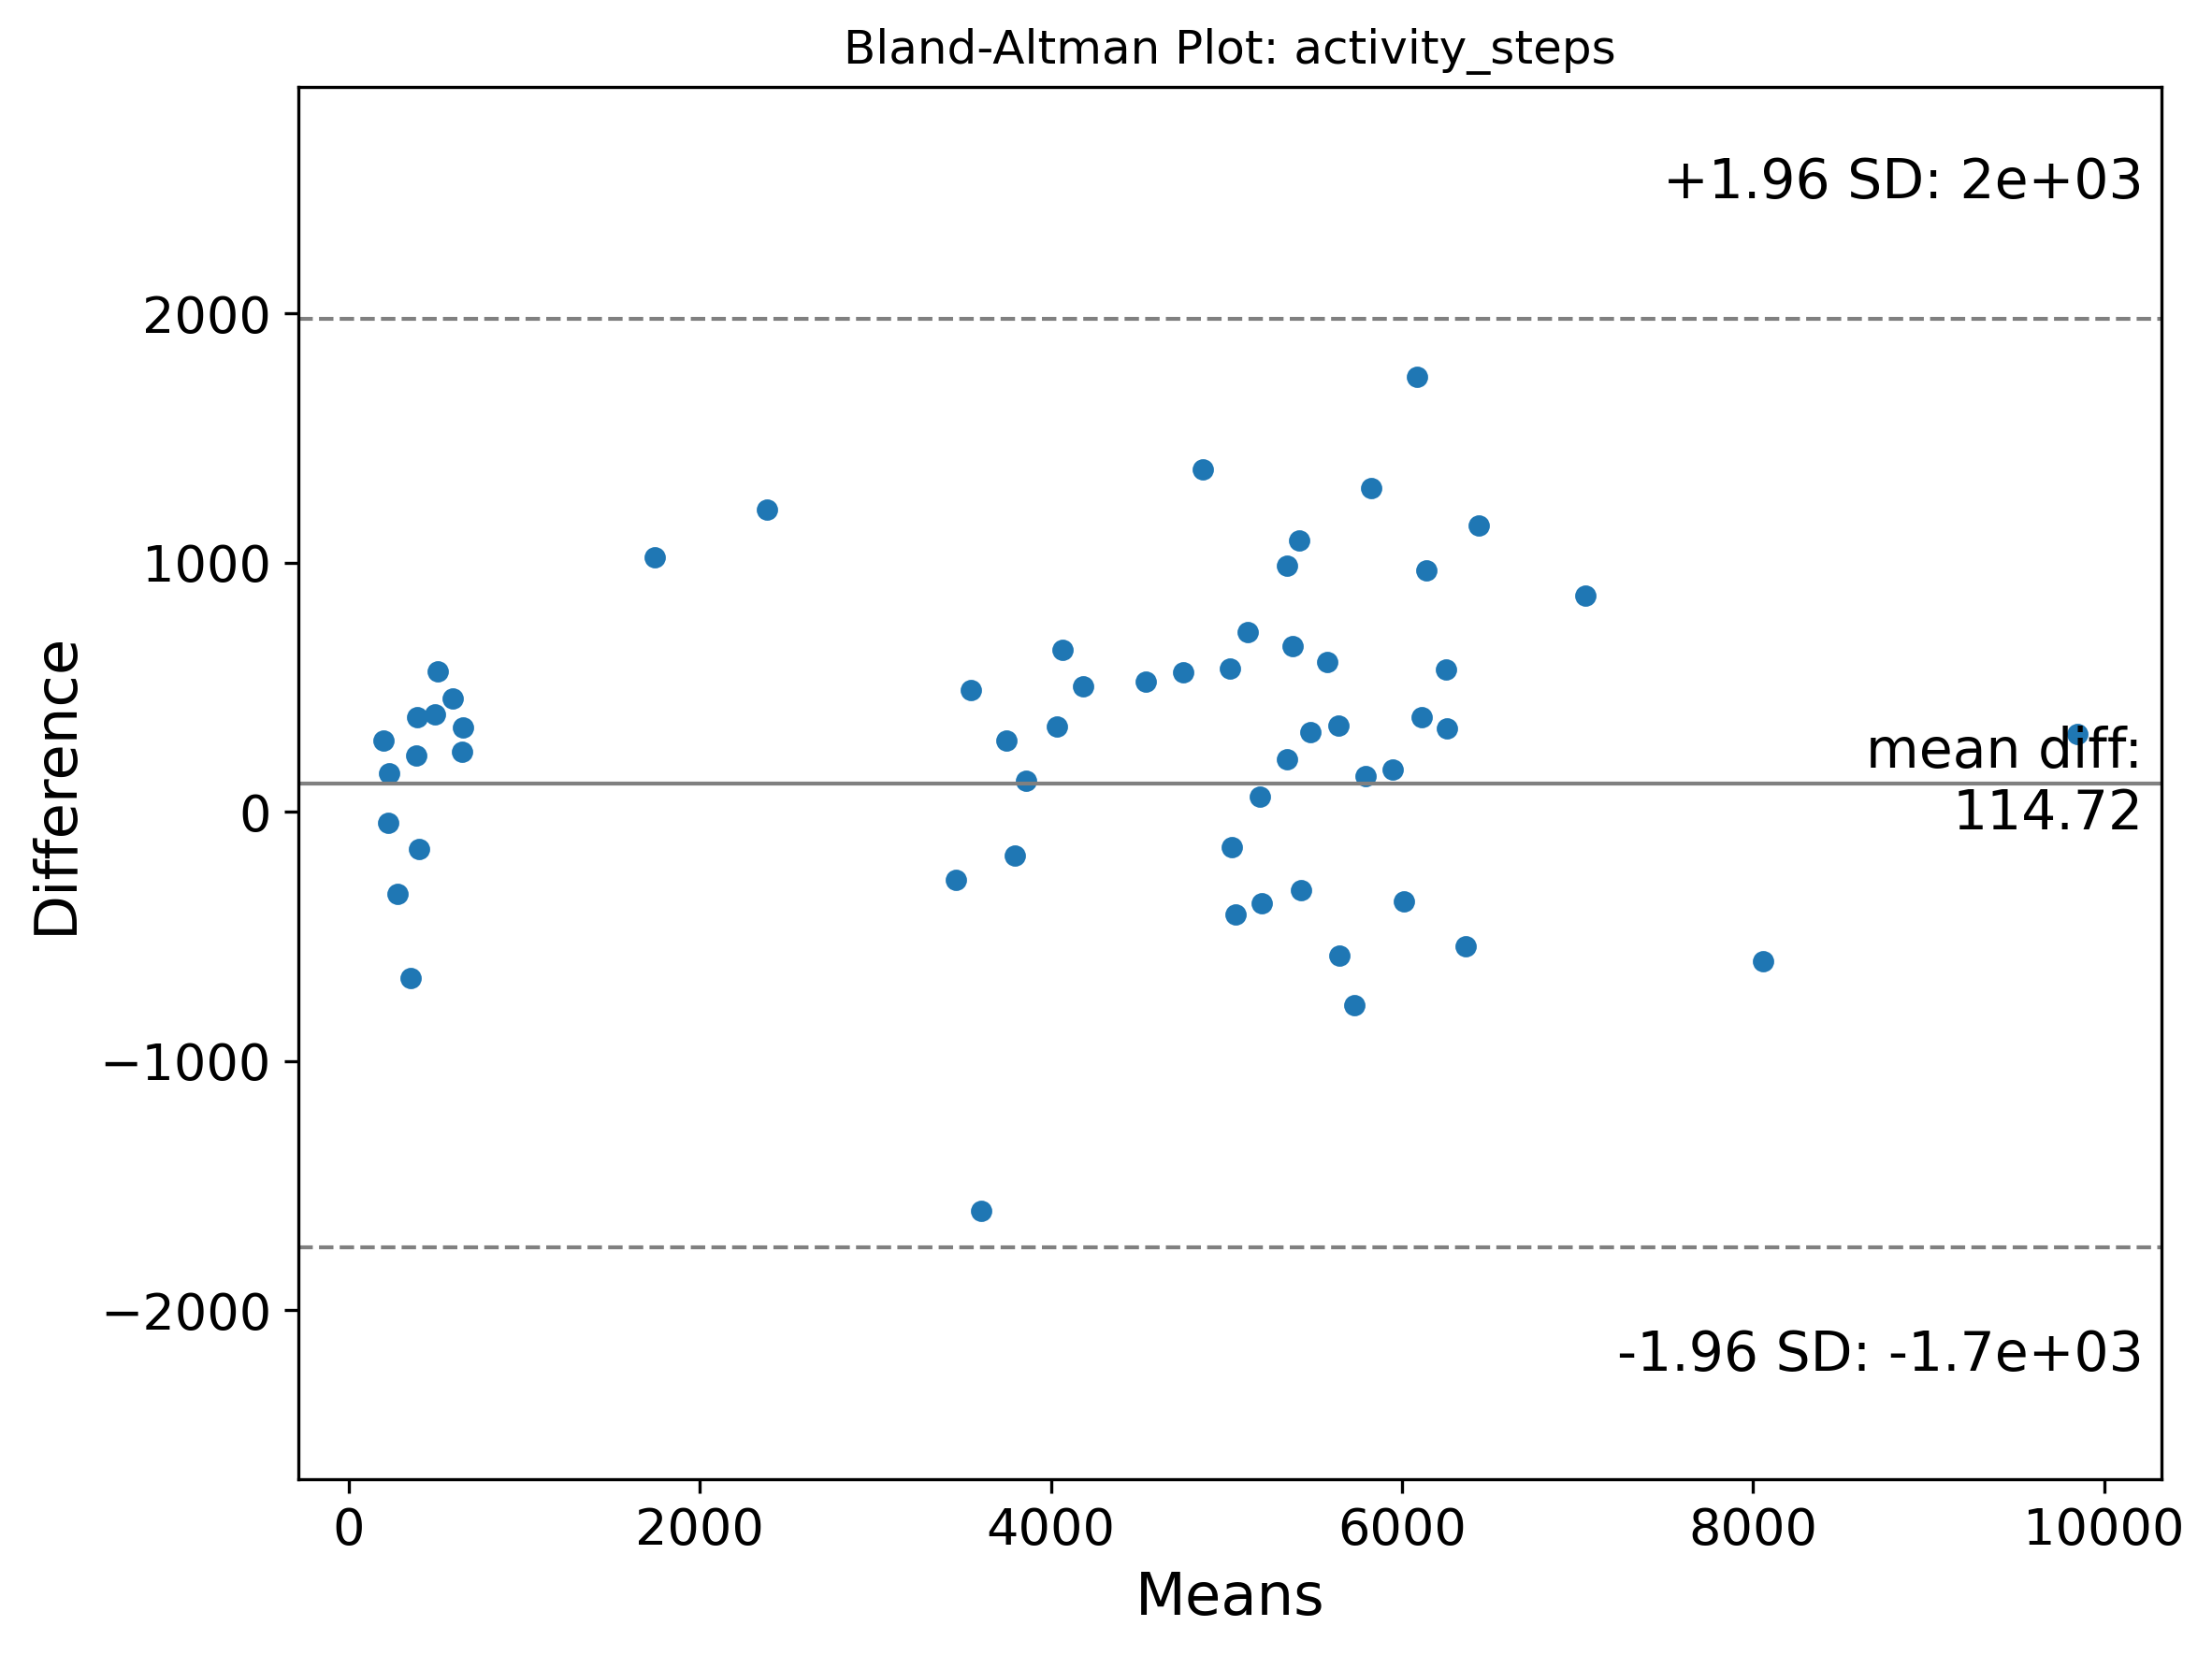

In [15]:
df_oura = df.loc[df["Type"] == f"{type}_Oura"]
df_withings = df.loc[df["Type"] == f"{type}_Withings"]
df_oura = df_oura[df_oura["date"].isin(df_withings["date"])]
df_oura = df_oura[df_oura[property].notna()]
df_withings = df_withings[df_withings["date"].isin(df_oura["date"])]
df_withings = df_withings[df_withings[property].notna()]
df_oura.set_index("date", inplace=True)
df_withings.set_index("date", inplace=True)
print(df_oura[property].values - df_withings[property].values)
zscores = np.abs(zscore(resultActivity[resultActivity[property].notna()][property]))
df_oura["zscores"] = zscores
df_withings["zscores"] = zscores
x = 0
a = df_oura[df_oura["zscores"] <= zscoreOutlier][property].values
print(len(df_withings))
b = df_withings[df_withings["zscores"] <= zscoreOutlier][property].values
print(len(b))
f, ax = plt.subplots(1, figsize = (8, 6))
plt.title(f"Bland-Altman Plot: {type}_{property}")
sm.graphics.mean_diff_plot(a, b, ax=ax)
# bland_altman_plot(a, b)
plt.show()
f.savefig("plot_noOutliers.pdf", bbox_inches='tight')

[  284.   380.   490.   455.   564.  -577. -1601. -5369.   576.  1211.
  1088.    59.   124.   650.   970.   341.   -46.   502.  1373.   209.
  -328.   320.   389.   570.   987.   602. -4024.   240.   287.  1747.
   868.  -274.  1021. -3291.   665. -5187.   722.   559.   333.  -315.
 -3906.  -177.   225.  1150.  -411. -4608. -2759.  -368.   154.  -142.
   523.   145.  -361. -3364. -4026.   340.   347.   378.   169.  -598.
  -541.  -776.  -666.  -150.   311.  1300.]


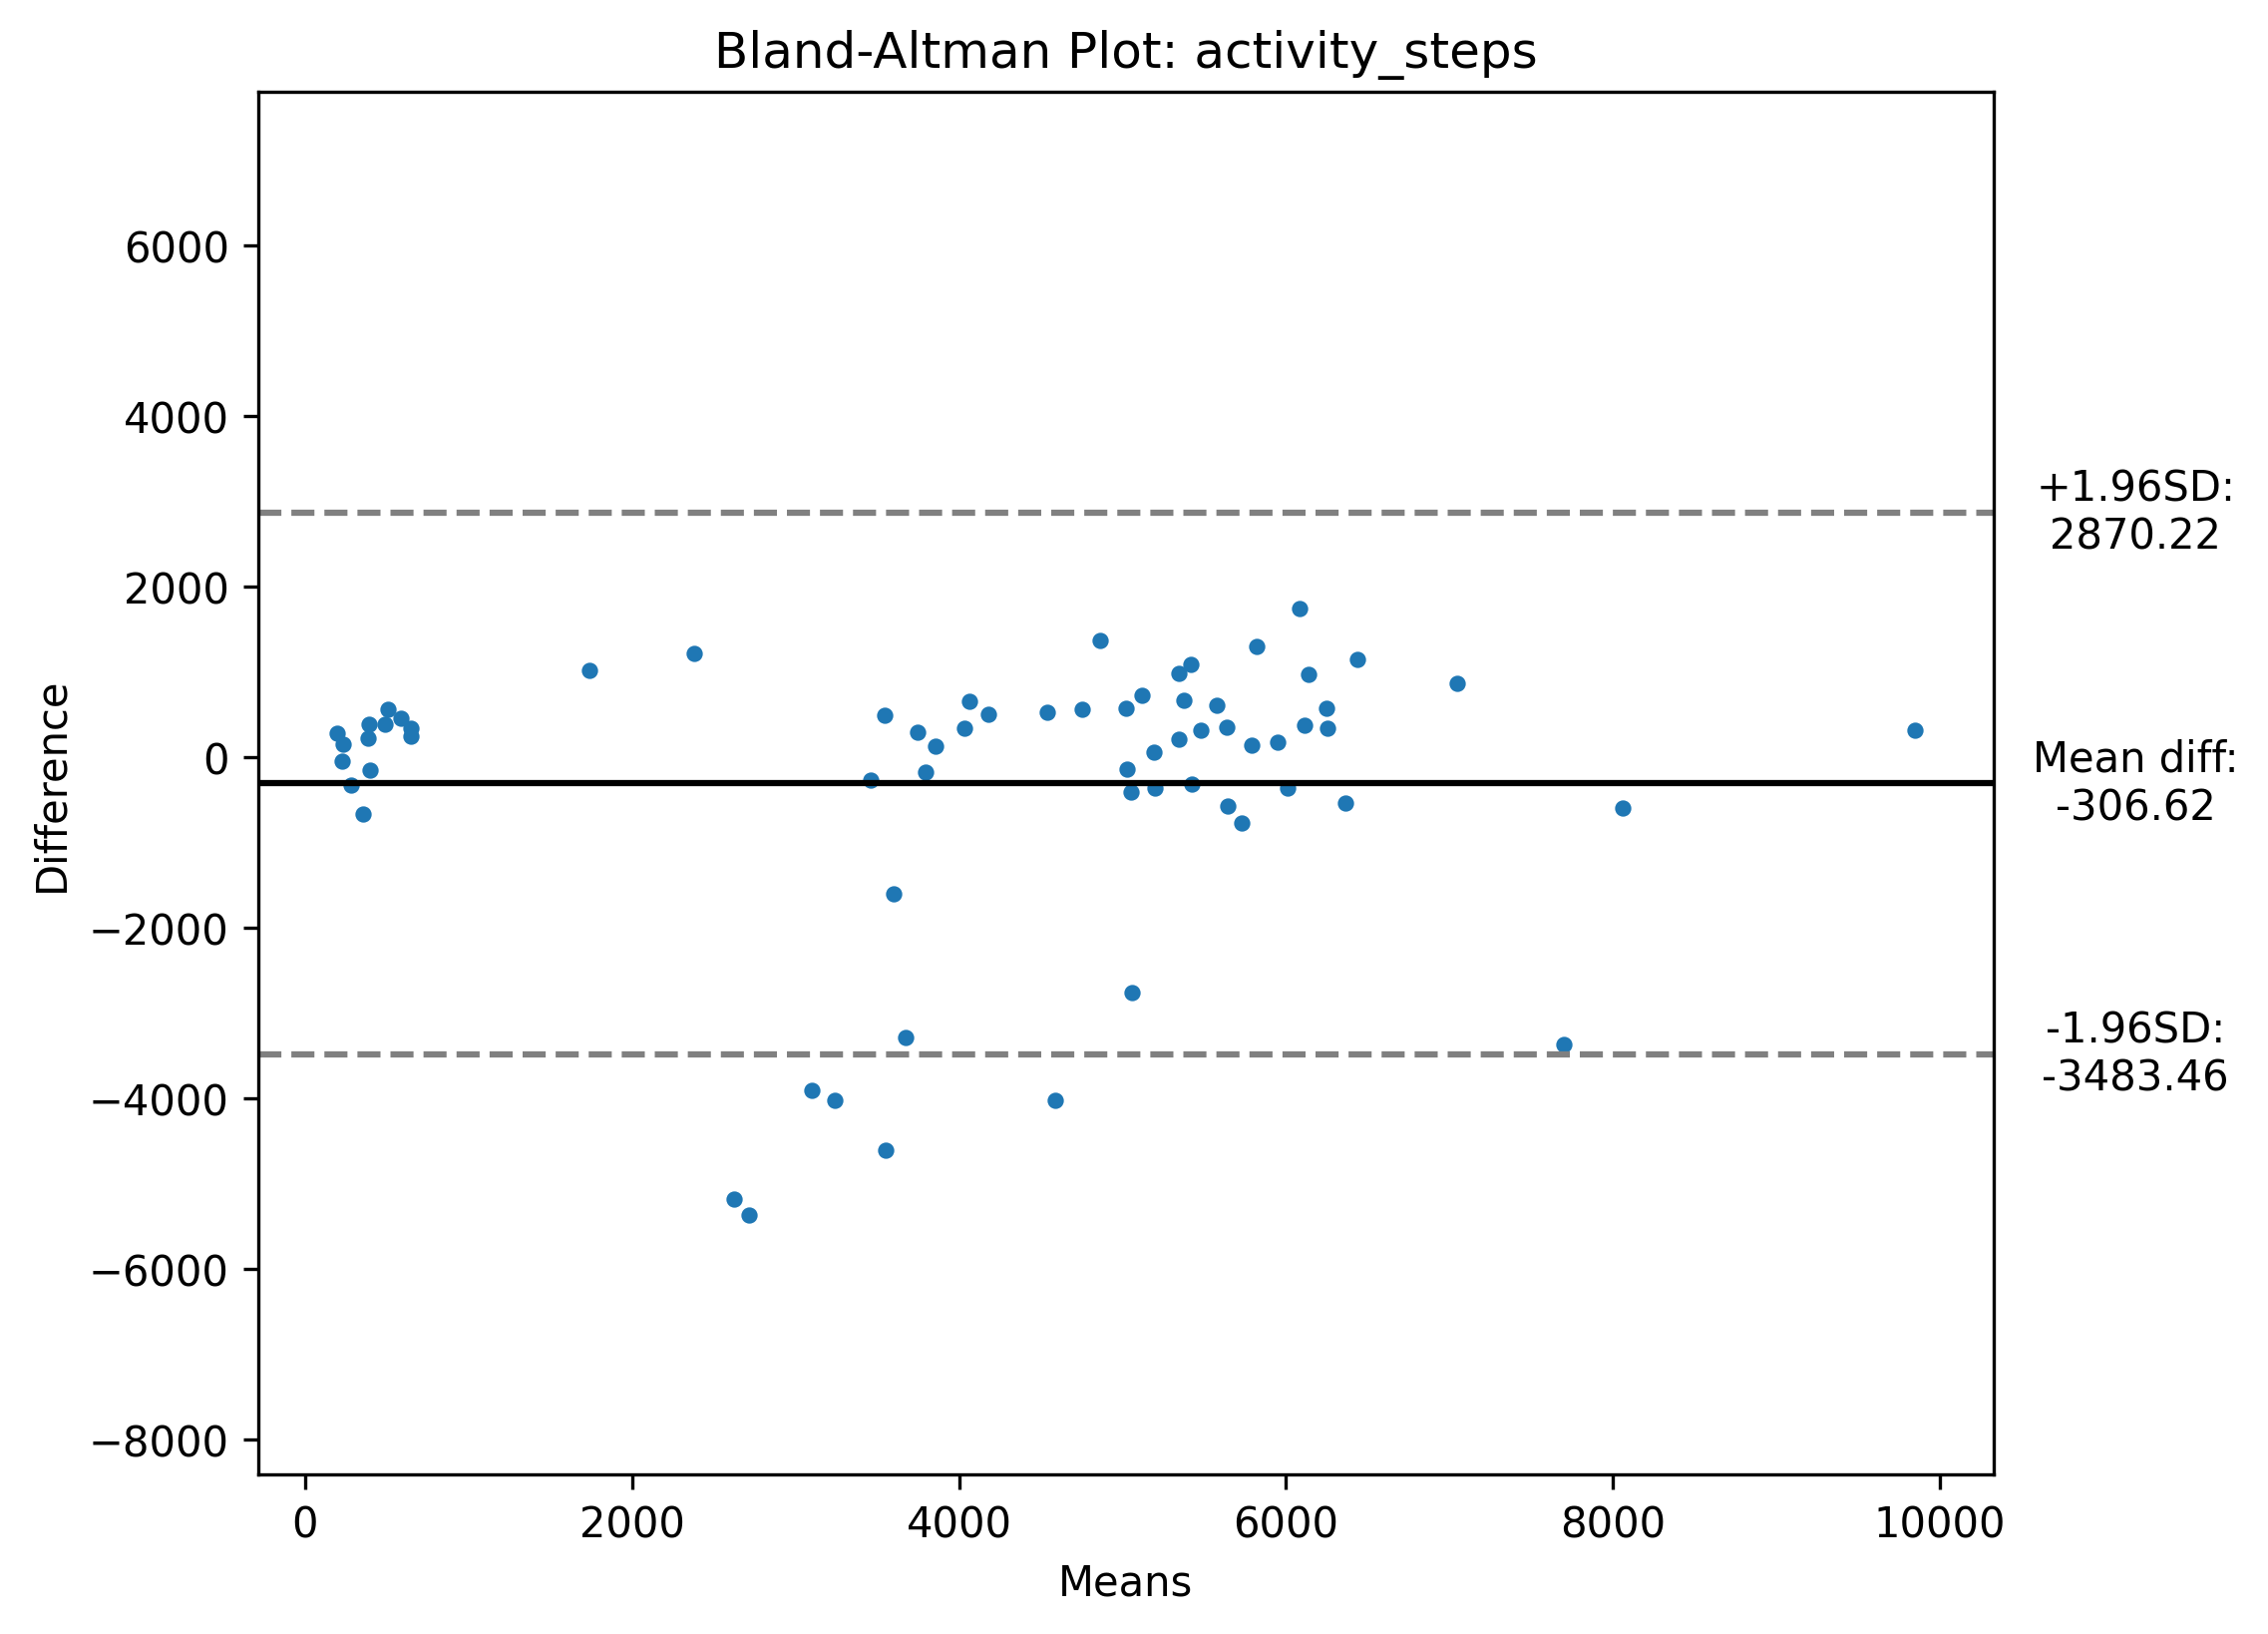

In [16]:

a = df_oura[property].values
b = df_withings[property].values
f, ax = plt.subplots(1, figsize = (8, 6))
plt.title(f"Bland-Altman Plot: {type}_{property}")
# sm.graphics.mean_diff_plot(a, b, ax=ax)
bland_altman_plot(a, b)
plt.show()
f.savefig("plot_outliers.pdf", bbox_inches='tight')


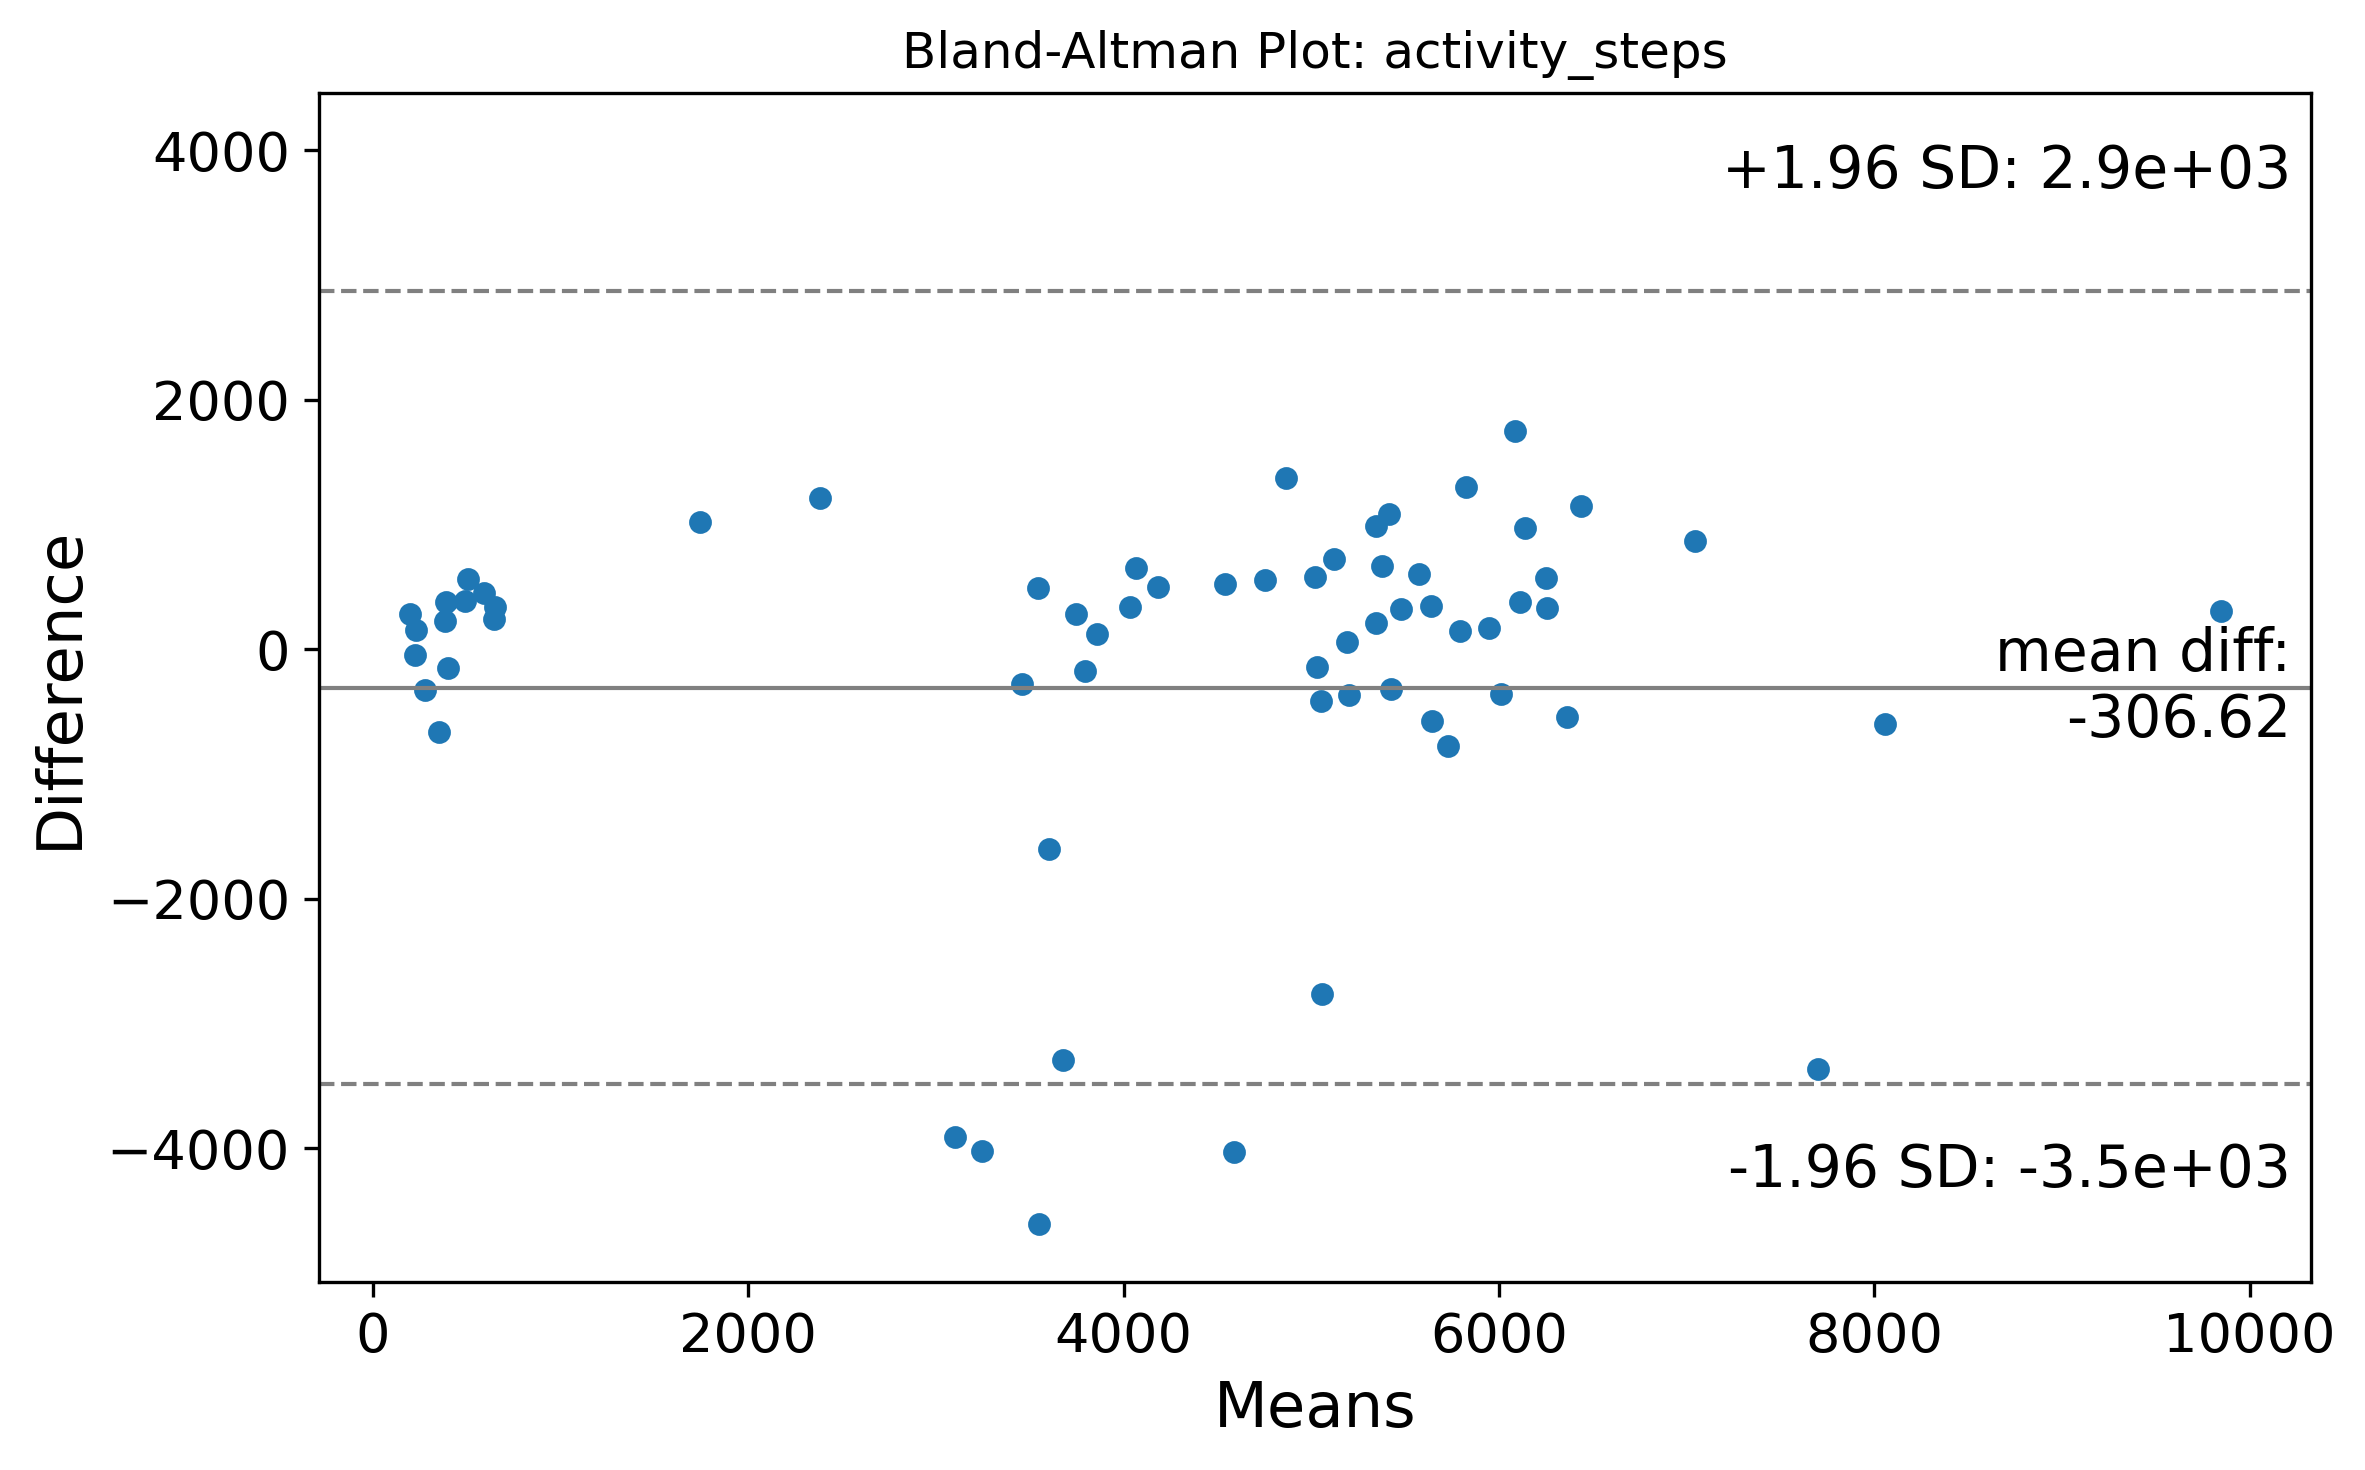

In [17]:
f, ax = plt.subplots(1, figsize = (8, 5))
plt.title(f"Bland-Altman Plot: {type}_{property}")
sm.graphics.mean_diff_plot(a, b, ax=ax)
plt.show()

sleepScore: 1.624116013216887e-18
sleepScore: 1.0571999999999, 23.604392727270497
lightSleepDuration: 2.3384270901169673e-11
lightSleepDuration: 1.083499999999897, 2837.763892856873
sleepLatency: 2.4292816132279243e-09
sleepLatency: 1.0872999999998967, 376.9306666666309
sleepEfficiency: 2.6051219916101875e-20
sleepEfficiency: 1.103399999999895, 6.876546428570773
totalSleepDuration: 0.014733396907999739
totalSleepDuration: 0.8941999999999178, 27.527333333330805
averageHR: 3.754822053306382e-12
averageHR: 1.119899999999893, 2.398452499999771
62
intenseActivity: 0.005627236441804457
intenseActivity: 1.1977999999998845, 677.8195645160637
565.8870967741935
61
caloriesBurned: 0.11578500189272835
caloriesBurned: 0.5666999999999539, 80.22502485245249
141.56524590163934
60
steps: 0.3575686980169376
steps: 0.4777999999999637, 321.50365666664226
672.8833333333333
63
moderateActivity: 1.614100350403509e-05
moderateActivity: 1.1147999999998937, 809.4863619046846
726.1269841269841
60
softActivity: 2

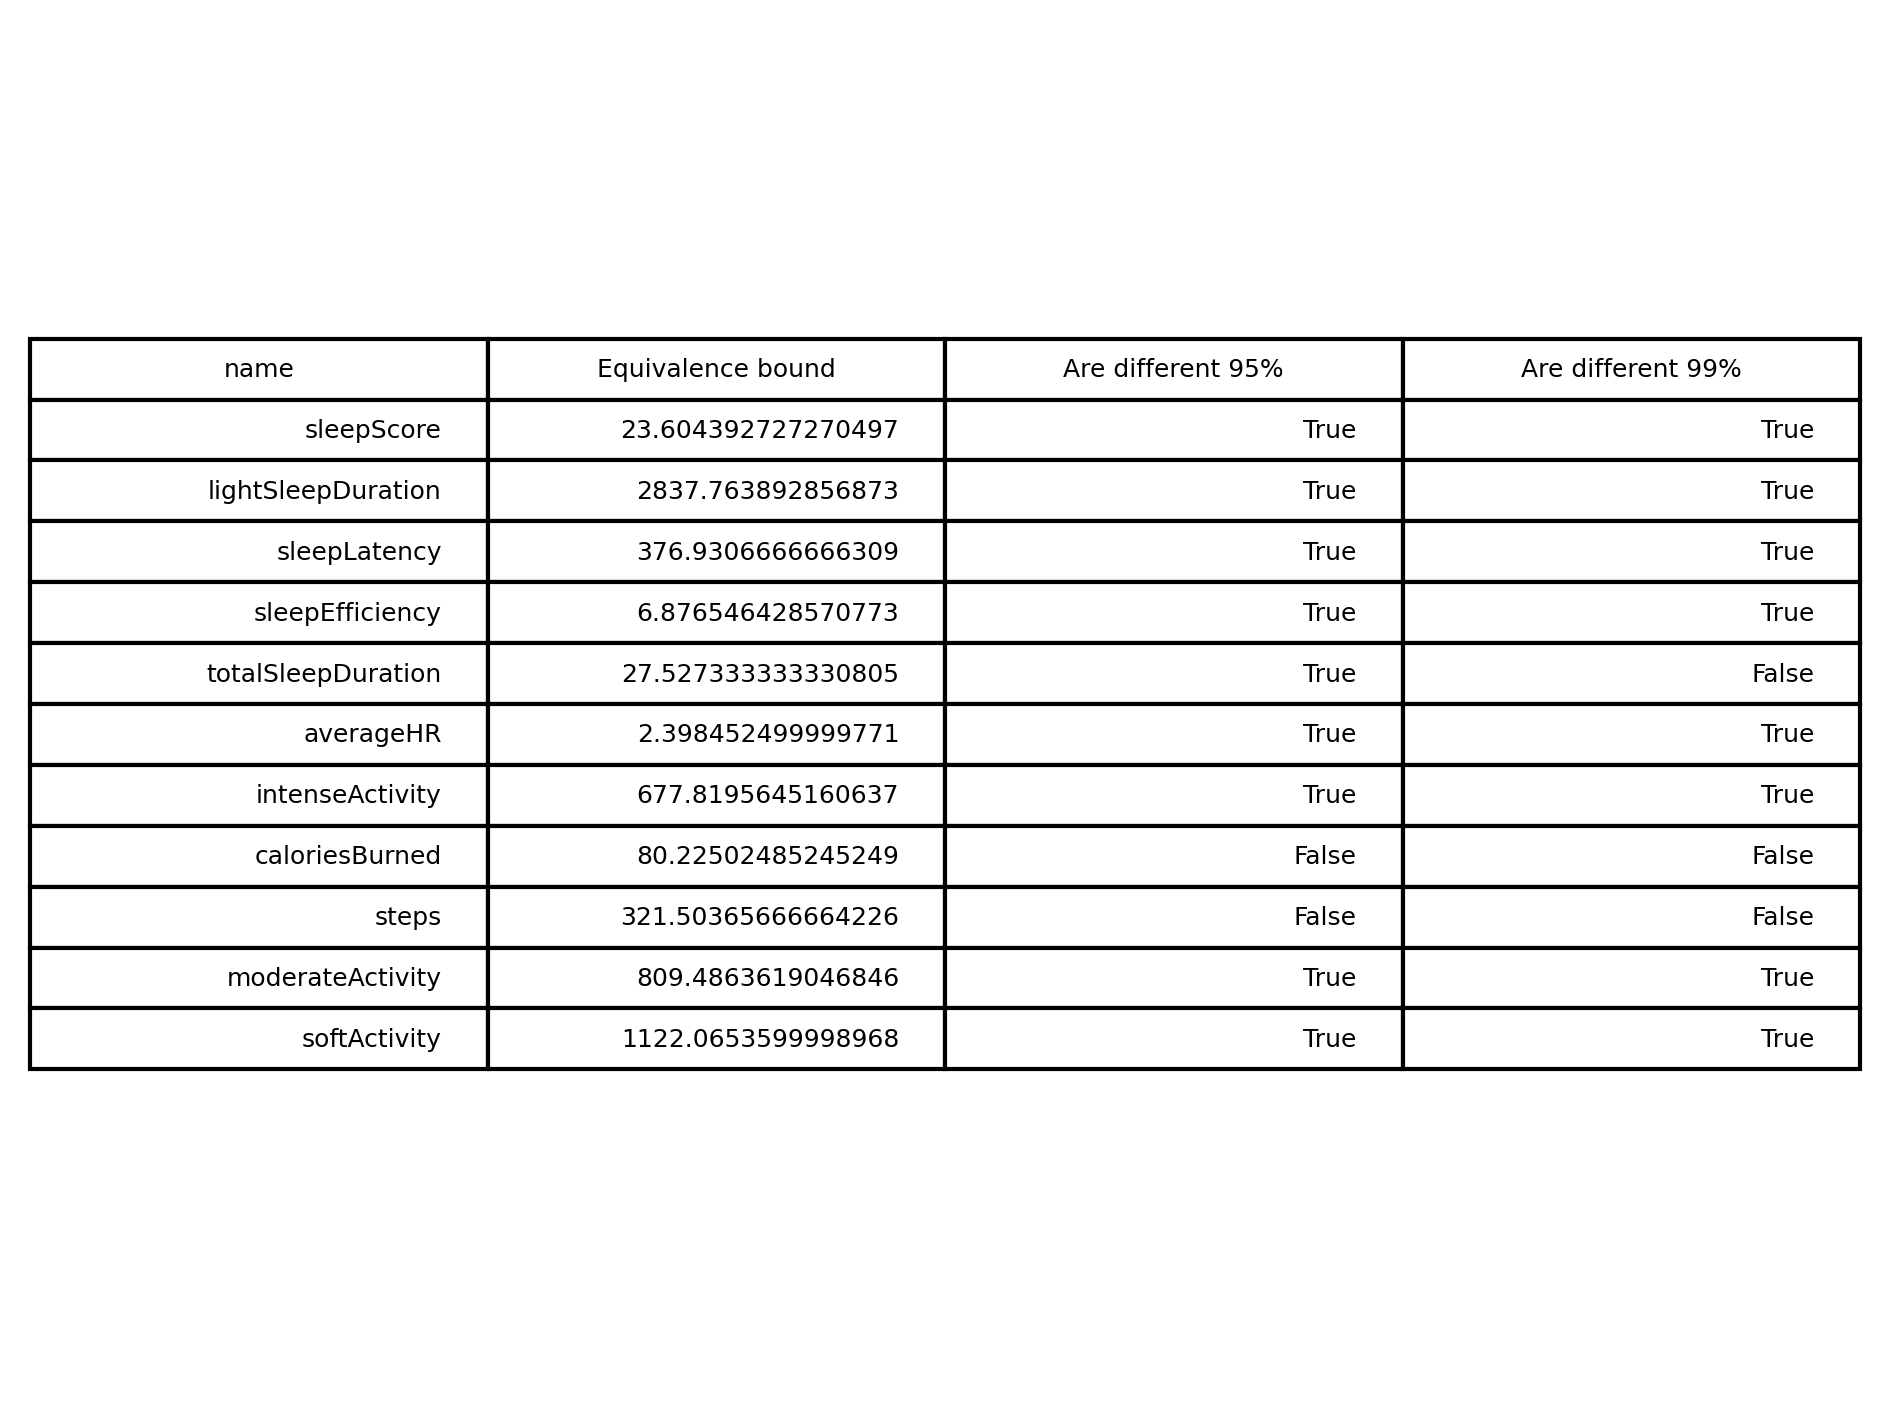

In [18]:
confidence = 0.05
increment = 0.0001
margin = 0
table_df = []
zscoreOutlier = 2
for p in categoriesSleep:
    
    df_oura = df.loc[df["Type"] == f"sleep_Oura"]
    df_withings = df.loc[df["Type"] == f"sleep_Withings"]
    df_oura = df_oura[df_oura["date"].isin(df_withings["date"])]
    df_oura = df_oura[df_oura[p].notna()]
    df_withings = df_withings[df_withings["date"].isin(df_oura["date"])]
    df_withings = df_withings[df_withings[p].notna()]
    df_oura.set_index('date', inplace=True)
    df_withings.set_index('date', inplace=True)

    zscores = np.abs(zscore(resultSleep[resultSleep[p].notna()][p]))
    df_oura["zscores"] = zscores
    df_withings["zscores"] = zscores
    x = 0
    a = df_oura[df_oura["zscores"] <= zscoreOutlier][p].values
    b = df_withings[df_withings["zscores"] <= zscoreOutlier][p].values
    p_two = stats.ttest_rel(a, b).pvalue
    is_in = p_two <= confidence
    is_in90 = p_two <= 0.1
    is_in95 = p_two <= 0.05
    is_in99 = p_two <= 0.01
    print(f"{p}: {p_two}")
    while True:
        
        margin = np.mean(np.abs(a - b)) * x
        p_val = tests.ttost_paired(a, b, -margin, margin)[0]
        
        if p_val >= confidence:
            x += increment
            continue
        print(f"{p}: {x}, {margin}")
        table_df.append([p, margin, is_in95, is_in99])
        break

for p in categoriesActivity:
    df_oura = df.loc[df["Type"] == f"activity_Oura"]
    df_withings = df.loc[df["Type"] == f"activity_Withings"]
    df_oura = df_oura[df_oura["date"].isin(df_withings["date"])]
    df_oura = df_oura[df_oura[p].notna()]
    df_withings = df_withings[df_withings["date"].isin(df_oura["date"])]
    df_withings = df_withings[df_withings[p].notna()]
    df_oura.set_index('date', inplace=True)
    df_withings.set_index('date', inplace=True)
    x = 0
    zscores = np.abs(zscore(resultActivity[p]))
    df_oura["zscores"] = zscores
    df_withings["zscores"] = zscores
    a = df_oura[df_oura["zscores"] <= zscoreOutlier][p].values
    b = df_withings[df_withings["zscores"] <= zscoreOutlier][p].values
    print(len(b))
    p_two = stats.ttest_rel(a, b).pvalue
    is_in90 = p_two <= 0.1
    is_in95 = p_two <= 0.05
    is_in99 = p_two <= 0.01
    print(f"{p}: {p_two}")
    while True:
        
        margin = np.mean(np.abs(a - b)) * x
        p_val = tests.ttost_paired(a, b, -margin, margin)[0]
        if p_val >= confidence:
            x += increment
            continue
        print(f"{p}: {x}, {margin}")
        table_df.append([p, margin, is_in95, is_in99])
        print(np.mean(np.abs(a - b)))
        break
table_df = pd.DataFrame(table_df)
table_df.head()
fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
ax.table(cellText=table_df.values, colLabels=["name", "Equivalence bound", "Are different 95%", "Are different 99%"], loc='center')
fig.tight_layout()

plt.show()
fig.savefig("results.pdf", bbox_inches='tight')
